# Denoising Autoencoder

In [1]:
import NBInclude: @nbinclude
@nbinclude("../Helpers/Base.ipynb");

In [40]:
read_params("NeuralExplicitAutoencoderUntuned")["hyp"]

Hyperparameters:
model                  => autoencoder
content                => explicit
implicit               => false
input_data             => explicit_implicit
input_alphas           => ["ExplicitUserItemBiases"]
output_data            => allitems
batch_size             => 1024
user_sampling_scheme   => 0.0
learning_rate          => 0.001
optimizer_weight_decay => 1.0e-5
optimizer              => ADAMW
seed                   => 20220524
num_users              => 4563688
holdout                => 0.5
temporal_holdout       => NaN
item_weight_decay      => 0.0
residual_alphas        => ["ExplicitUserItemBiases"]
temporal_weight_decay  => 0.38285452
user_weight_decay      => -1.0


In [43]:
0.15^0.38285452

0.4836852173658449

In [44]:
spl = "validation"
truth = get_split(spl, "explicit")
df = read_alpha(
    [
        "ExplicitUserItemBiases",
        "ExplicitItemCF.powerlaw",
        "NeuralExplicitAutoencoderUntuned",
    ],
    spl,
    "explicit",
    false,
) #
df = @set df.rating = (truth.rating .- df.rating) .^ 2

RatingsDataset
  user: Array{Int32}((2697461,)) Int32[114, 290, 290, 290, 290, 290, 306, 386, 386, 386  …  4563552, 4563552, 4563584, 4563584, 4563584, 4563584, 4563584, 4563584, 4563584, 4563584]
  item: Array{Int32}((2697461,)) Int32[22007, 18387, 14580, 6827, 7406, 6866, 13100, 12272, 5777, 231  …  5295, 10421, 11989, 21409, 18748, 13828, 18871, 18381, 2640, 12331]
  rating: Array{Float32}((2697461,)) Float32[0.12842347, 0.4779437, 11.103849, 7.6271143, 2.0942051, 2.0177166, 0.015850758, 1.7025579, 0.13058697, 0.025220206  …  0.24057947, 0.016651507, 1.6645786, 0.58602464, 1.9287434, 2.2467883, 0.13040885, 0.71364516, 3.878827, 0.6013016]
  timestamp: Array{Float32}((0,)) Float32[]
  user_timestamp: Array{Float32}((0,)) Float32[]
  item_timestamp: Array{Float32}((0,)) Float32[]
  status: Array{Int32}((0,)) Int32[]
  completion: Array{Float32}((0,)) Float32[]
  rewatch: Array{Int32}((0,)) Int32[]
  source: Array{Int32}((0,)) Int32[]


In [31]:
using Statistics

In [32]:
function per_user_mse(df)
    errors = zeros(Float32, num_users())
    counts = zeros(Float32, num_users())

    for i = 1:length(df.rating)
        errors[df.user[i]] += df.rating[i]
        counts[df.user[i]] += 1
    end

    Threads.@threads for i = 1:length(errors)
        if counts[i] > 0
            errors[i] /= counts[i]
        end
    end
    errors, counts
end

per_user_mse (generic function with 1 method)

In [33]:
tcounts = get_counts("training", "explicit"; per_rating = false);

In [34]:
split_df = df
mses, counts = per_user_mse(split_df)
mean(mses[(counts.>0)]),
mean(mses[@. (counts > 0) & (tcounts > 10)]),
mean(mses[@. (counts > 0) & (tcounts > 50)])

(1.8213294f0, 1.5330403f0, 1.449889f0)

In [35]:
quantile(counts[counts.>0], 0:0.1:1)

11-element Vector{Float64}:
    1.0
    1.0
    1.0
    2.0
    2.0
    3.0
    4.0
    6.0
    9.0
   17.0
 9064.0

In [36]:
quantile(tcounts[counts.>0], 0:0.1:1)

11-element Vector{Float64}:
     0.0
     0.0
    10.0
    36.0
    63.0
    93.0
   129.0
   176.0
   247.0
   382.0
 12374.0

In [37]:
split_df = df
mses, counts = per_user_mse(split_df)
mse_by_count = zeros(500)
for i = 1:length(mse_by_count)
    mse_by_count[i] = mean(mses[@. (counts > 0) & (tcounts == i - 1)])
end

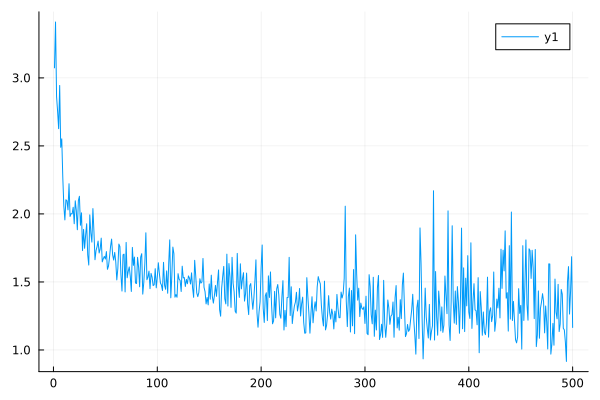

In [38]:
using Plots
plot(mse_by_count)